# Fire Pulse Analysis
Last update: 12 Sept 2017

**Synopsis:** This notebook will read in fire pulse data for processing and analysis.  The data will be normalized and time aligned.

**Abstract:** Fire pulse data taken from various tests will be processed and analyzed to show the similarity of the characteristics of fire pulse from the UCHFS1000 firing into a LEEFI or CVR compared to the NAWC FTSA when firing into a CVR for qualification and acceptance testing. Three fire pulses will be analyzed.  All the fire pulses were taken at ambient temperature. These are:
- FIRE 800V:  The highest stimulus successful fire pulse from the Neyer tests.
- FIRE 720V: The lowest stimulus successful fire pulse from the Neyer tests.
- CVR Fire Pulse: A sample of the FTSA fire pulse taken during acceptance testing measured on a CVR.

**Introduction:**  The purpose of this analysis is to show that the current viewing resistor (CVR) used for acceptance and qualification testing represents an adequate load that simulates a low energy exploding foil initiator (LEEFI).  The LEEFI is an explosive device that accepts a high voltage impulse from the rapid discharge of a capacitor and initiates a detonation wave used to initiate a secondary explosive device or that is propagated down a detonation cord.  This analysis will compare the peak amplitude of the stimulus pulse and the rise time measured during the explosive initiation reliability tests to the fire pulse measured into a CVR.  A LEEFI is a one time use explosive device and cannot be used for normal testing of the fight termination safe and arm (FTSA).  This analysis will show that the CVR is a suitable substitute for the LEEFI when performing functional tests of the FTSA.

**Scope:**  The data analyzed was taken at ambient temperature.  Data at hot (81°C) and cold (-54°C) temperatures was not made available for this analysis.  While the data is different at hot and cold temperatures the results will be similar in so far as the pulse shape should track with temperature. 

**Analysis method:**  The method used to establish that the CVR does represent an actual LEEFI is to compare shape of the leading edge of the fire pulse from data taken during actual firing to data from a CVR.  First the fire pulse data will be normalized and time aligned to the peak of the pulse.  The fire pulses will be plotted on a common graph so that the general shape of the data can be visually inspected.  Then the rise time of the leading edge of the fire pulse will be calculated from the data.  For this analysis the rise time is taken to be the time difference between the 10% and 90% points on the leading edge of the pulse.  Finally the root-mean-square error (RMSE) will be computed between the normalized FIRE_800V data set and the other data sets to measure the degree of correlation.  If the fire pulses are highly correlated, we can conclude that the CVR represents a realistic load and is suitable for use during testing.

**General background:** The FTSA is an electronic module that includes various safety features as well as the high voltage circuitry needed to charge the firing capacitor to about 1000 volts.  When a terminate command is received, the high voltage capacitor is discharged into the LEEFI to initiate the explosive event.

The LEEFI is a device that consist of a metal foil element, a layer of an insulating film and an explosive pellet.  When the capacitor discharges through the metal foil, a large amount of energy is deposited at very fast rate into the foil, the current heats the foil bridge through the melting, boiling and vaporization phases up to the plasma state, giving off thermal energy and shock waves. The insulating film is sheared off and accelerated to very high speed which impacts and detonates the explosive pellet.  A low resistance and inductive circuit is required to achieve a fast energy rise time into the foil.  Neyer D-Optimal tests were conducted to determine experimentally the mean stimulus and standard deviation required to initiate the explosive pellet.  The stimulus being the voltage level on the high voltage capacitor just prior to discharge.

A CVR resistor is used to simulate the LEEFI during testing of the the FTSA.  Since it’s not practical or safe to use an actual LEEFI and there is no easy way to monitor the current rise time during testing when the LEEFI is installed, a special type of resistor is used in place of the LEEFI for testing. The value of the CVR is about 0.5 ohms, since this represents the dynamic resistance of the metal foil for testing.  The DC resistance of the metal foil is about 150 milliohms. When the capacitor is discharged, thousands of amps flow through the foil and the current path transitions from the solid metal conductor of the foil to a plasma before being interrupted by the open circuit of the burnt out foil.  The dynamic resistance can rise to several ohms during this transient event.  A CVR value of about 0.5 ohms represents a load that allows the current flow from the capacitor to reasonably match the LEEFI.

During the Neyer D-Optimal tests, the stimulus level was adjusted so that about 50% of the tests were successful and 50% were not.  In order to compare the fire pulse from the CVR to the LEEFI fire pulses, the data need was normalized because the voltage levels were in each case different.  The data was then time aligned to the peak and the time index was adjusted to set t = 0 at the peak.  The data for FIRE_720V and the CVR fire pulse was a little noisy so all the data sets were smoothed when calculating the rise time of the leading edge of the pulse.  The voltage resolution on the CVR_TEST was about 0.4 volts.  The lack of resolution required smoothing to obtain accurate results.

**Comparison of the pulse leading edges:**  Rise times of the leading edge of the fire pulses were calculated.  The rise time ranged from 59 to 79 ns.  The shape of the leading edges of the pulses were compared to each other. The CVR_test data had a faster rise time since the FIRE_800V and FIRE_720V tests included extra inductance from the strip line extension used during the Neyer tests.  The root-mean-square error (RMSE) was calculated between the FIRE_800V data set, the FIRE-720V data set and the CVR_TEST data set.

The root-mean-square error (RMSE) is a frequently used measure of the differences between two data sets. RMSE is the square root of the average of squared errors.  The RMSE combines information concerning average error with information concerning variation in the errors. The effect of each error on RMSE is proportional to the size of the squared error thus larger errors have a disproportionately large effect on RMSE. RMSE is sensitive to outliers.

A polynomial curve fit to the rising edge of the FIRE_800V data set was calculated since the this data set was chosen to be the reference data set for this analysis.  A 5th order polynomial provided a remarkably good fit to the data for the rising edge segment of the fire pulse.  The data set for the FIRE-720V and the CVR_TEST were different lengths so it was necessary to use the poly as the reference for comparison since the number of point could be adjusted to match.

The RMSE between the FIRE_800V and the FIRE-720V is 0.05 and the RMSE between the FIRE_800V and the CVR_TEST is 0.047.

**CVR test limits:** The CVR can be used to measure the amplitude of the fire pulse during testing.  The voltage across the CVR is proportional to the current flowing through the CVR.  Using Ohm’s law, the peak voltage can be calculated.  The minimum peak voltage should be the maximum all fire voltage, which was determined by the Neyer tests, plus the safety margin of 100 volts.  The maximum allowed voltage can be determined by the amount of regulation provided by the switching power supply, the maximum rated voltage for the capacitor and the derating. The rise time of the fire pulse is limited by the inductance in the fire circuit.  A test limit for the rise time could be determined from the average rise time measured during the Neyer tests plus one standard deviation.  The Neyer testing included a small penalty from the extra inductance from the strip line extension used during the test.

**Conclusions:** The rising edge characteristics of the two fire pulses and the CVR pulse are extremely similar to each other.  Visual inspection of the plotted data as well as the RMSE calculations show a high degree of similarity.  The CVR is acceptable to use for acceptance and qualification testing of the FTSA.


# Python code
[Python](https://en.wikipedia.org/wiki/Python_(programming_language) is a widely used high-level programming language for general-purpose programming, created by Guido van Rossum and first released in 1991. An interpreted language, Python has a design philosophy that emphasizes code readability (notably using whitespace indentation to delimit code blocks rather than curly brackets or keywords), and a syntax that allows programmers to express concepts in fewer lines of code than might be used in languages such as C++ or Java. The language provides constructs intended to enable writing clear programs on both a small and large scale.  Python features a dynamic type system and automatic memory management and supports multiple programming paradigms, including object-oriented, imperative, functional programming, and procedural styles. It has a large and comprehensive standard library.

The python code is run from within a jupyter notebook.  A [Jupyter](http://jupyter.org/) notebook is an browser based application that allows you to create and share documents that contain live code, equations, visualizations and explanatory text. It is designed to make data analysis easier to share and reproduce.

## Load some python modules
These modules are from the [SciPy](https://en.wikipedia.org/wiki/SciPy) open source Python library.  [SciPy](https://www.scipy.org/) is an open source Python library used for scientific computing and technical computing. SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.  SciPy builds on the NumPy array object and is part of the NumPy stack which includes tools like Matplotlib, pandas and SymPy, and an expanding set of scientific computing libraries.

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import scipy.fftpack
from scipy.signal import blackman
from scipy.signal import tukey
import scipy.stats as stats
import matplotlib.pyplot as plt

## Load fire pulse data from files
Fire pulse data was previously sliced from much longer data sets and saved to files.  Here only the main pulse is loaded.

In [2]:
df1 = pd.read_pickle('FIRE_800V.pkl')
df2 = pd.read_pickle('FIRE_720V.pkl')
df3 = pd.read_pickle('FTSA Fire Pulse.pkl')

## Normalize and time align the data
- normalize data to 1
- convert time base to nsec
- time align peak to t=0

In [3]:
# FIRE 800V
x1 = df1['Time'].values
y1 = df1['Voltage'].values
y1 = y1/y1.max()
x1 *= 1e9
y1_peak_index = y1.argmax()
x1 -= x1[y1_peak_index]

In [4]:
# FIRE 720V
x2 = df2['Time'].values
y2 = df2['Voltage'].values
y2 = y2/y2.max()
x2 *= 1e9
y2_peak_index = y2.argmax()
x2 -= x2[y2_peak_index]

In [5]:
# CVR Fire Pulse
x3 = df3['Time'].values
y3 = df3['Voltage'].values
y3 = y3/y3.max()
y3_peak_index = y3.argmax()
x3 -= x3[y3_peak_index]

## Plot the data

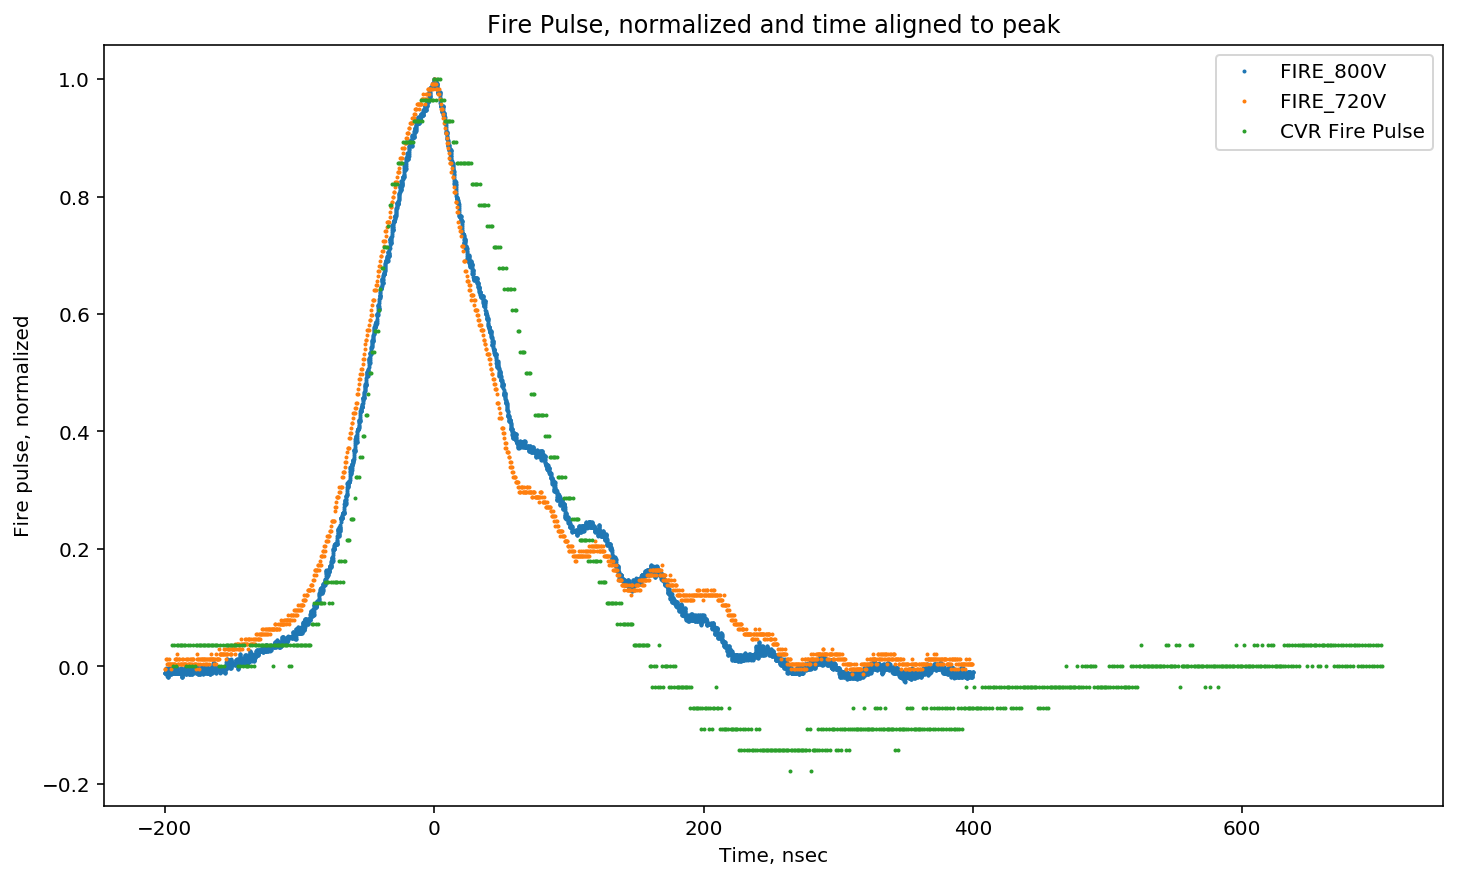

In [6]:
# plot the fire pulse
plt.plot(x1,y1,'o', markersize=1)
plt.plot(x2,y2,'o', markersize=1)
plt.plot(x3,y3,'o', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse, normalized')
plt.legend(['FIRE_800V', 'FIRE_720V', 'CVR Fire Pulse'], loc='best')
plt.title('Fire Pulse, normalized and time aligned to peak')
plt.show()

## Plotting only the leading edge of the fire pulses

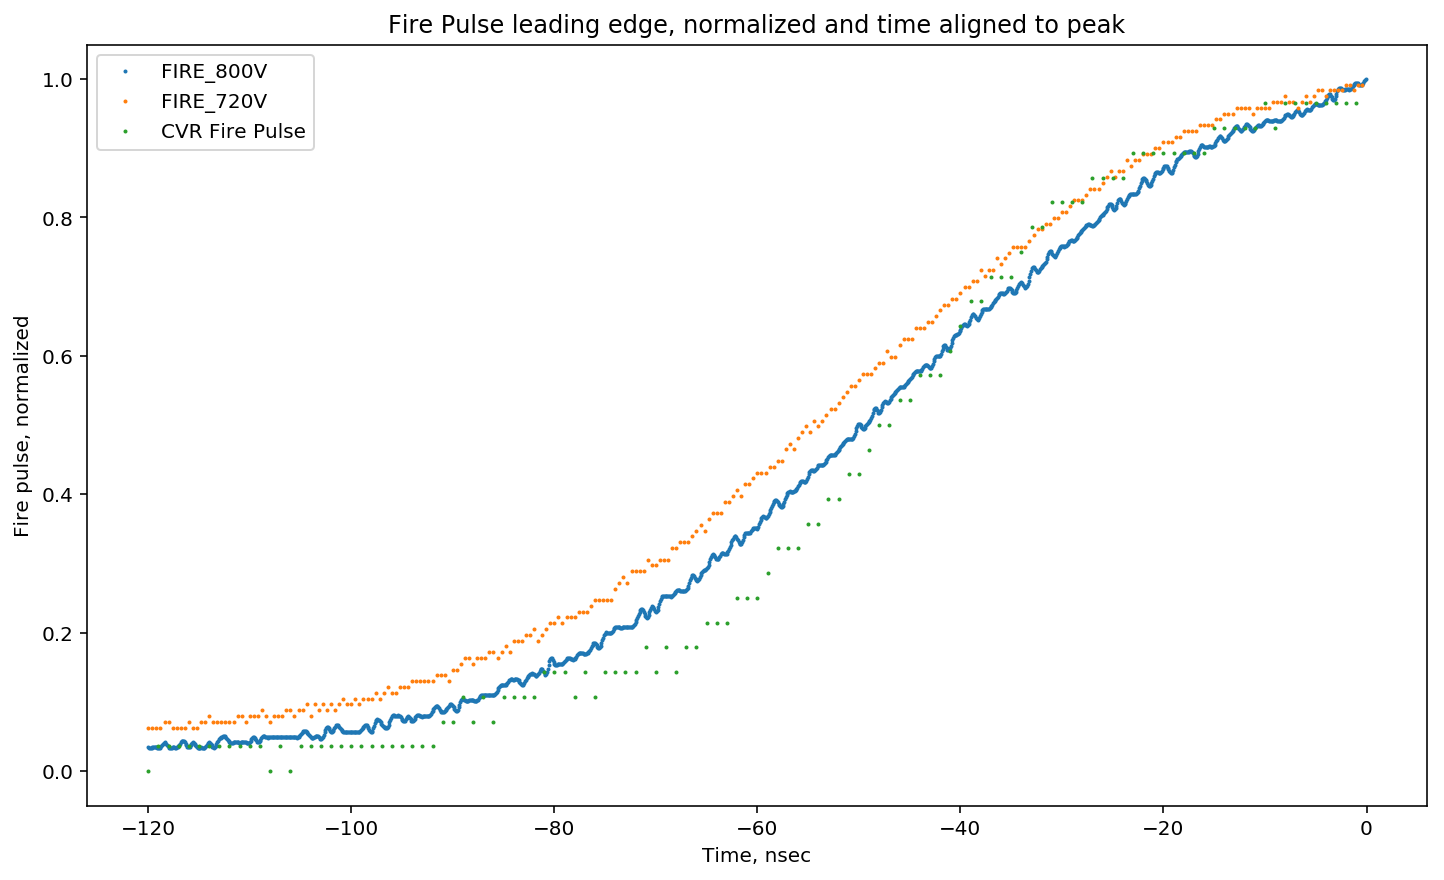

In [7]:
# plot the fire pulse
plt.plot(x1[y1_peak_index-1500:y1_peak_index],y1[y1_peak_index-1500:y1_peak_index],'o', markersize=1)
plt.plot(x2[y2_peak_index-300:y2_peak_index],y2[y2_peak_index-300:y2_peak_index],'o', markersize=1)
plt.plot(x3[y3_peak_index-120:y3_peak_index],y3[y3_peak_index-120:y3_peak_index],'o', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse, normalized')
plt.legend(['FIRE_800V', 'FIRE_720V', 'CVR Fire Pulse'], loc='best')
plt.title('Fire Pulse leading edge, normalized and time aligned to peak')
plt.show()

## Calculate rise time

The rise time will be calculated on the smoothed data set.  A Savitzky–Golay filter was be used to smooth the data.

A [Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter is a digital filter that can be applied to a set of digital data points for the purpose of smoothing the data, that is, to increase the signal-to-noise ratio without greatly distorting the signal. This is achieved, in a process known as convolution, by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares.

### Rise time for FIRE_800V

In [8]:
# consider only the rising edge
x1_rise = x1[y1_peak_index-1500:y1_peak_index]
y1_rise = y1[y1_peak_index-1500:y1_peak_index]

y1_filtered = savgol_filter(y1_rise, 51, 3)  # filter the data

index_90pc = (np.abs(y1_filtered-y1_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y1_filtered-y1_filtered.max()*0.1)).argmin()
rise_time = x1_rise[index_90pc]-x1_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y1_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y1_filtered[index_90pc], x1_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y1_filtered[index_10pc], x1_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.997 volts
90% voltage value: 0.897 volts at -16 ns
10% voltage value: 0.099 volts at -89 ns
rise time: 72 ns


#### Plot the 90% and 10% points on the curve

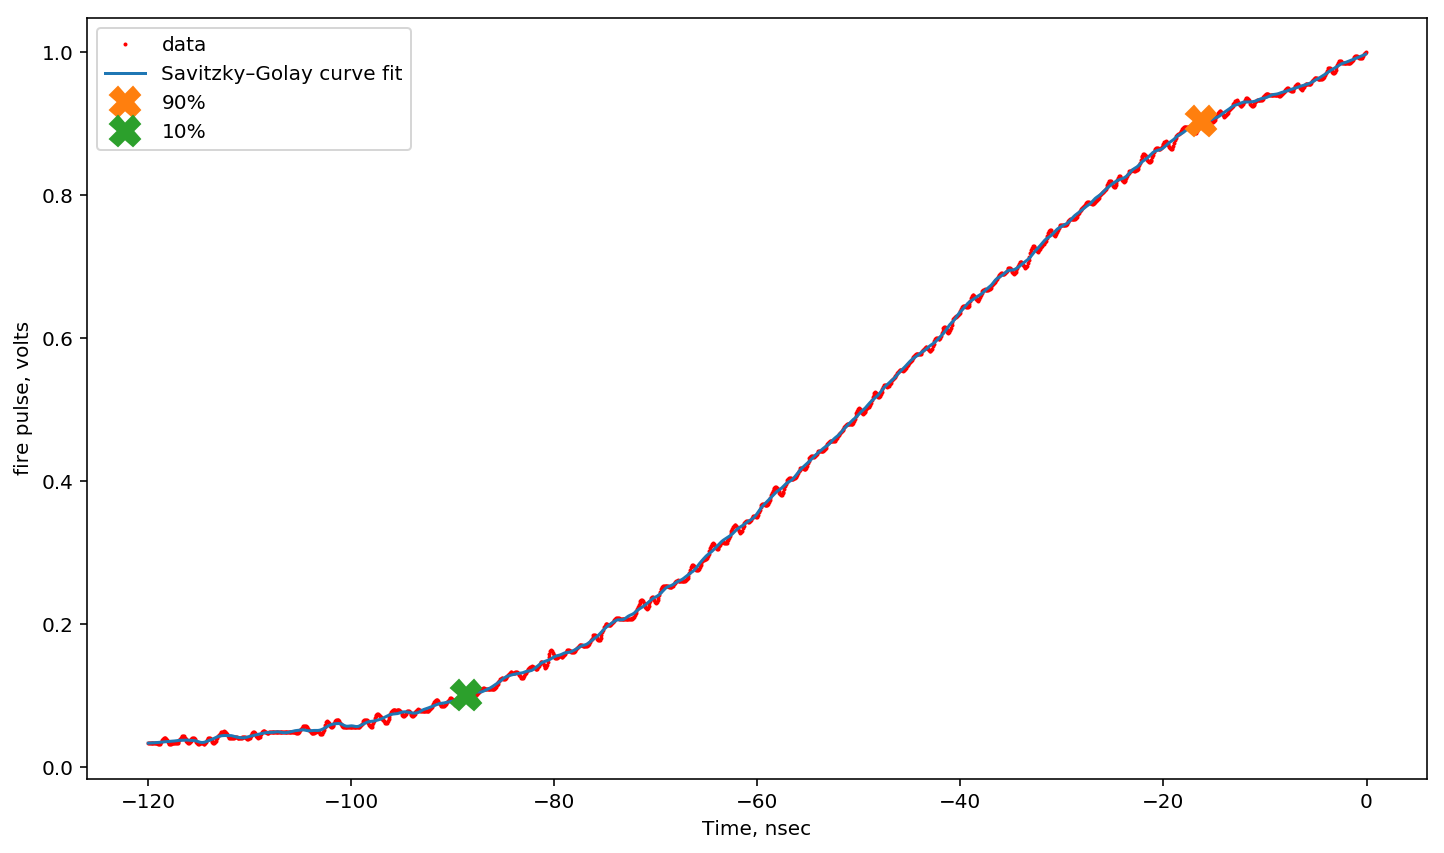

In [9]:
plt.plot(x1_rise,y1_rise,'ro', markersize=1)
plt.plot(x1_rise,y1_filtered)
plt.plot(x1_rise[index_90pc],y1_rise[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x1_rise[index_10pc],y1_rise[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

### Rise time for FIRE_720V

In [10]:
# consider only the rising edge
x2_rise = x2[y2_peak_index-300:y2_peak_index]
y2_rise = y2[y2_peak_index-300:y2_peak_index]

y2_filtered = savgol_filter(y2_rise, 51, 3)  # filter the data
index_90pc = (np.abs(y2_filtered-y2_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y2_filtered-y2_filtered.max()*0.1)).argmin()
rise_time = x2_rise[index_90pc]-x2_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y2_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y2_filtered[index_90pc], x2_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y2_filtered[index_10pc], x2_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.993 volts
90% voltage value: 0.895 volts at -21 ns
10% voltage value: 0.099 volts at -100 ns
rise time: 79 ns


#### Plot the 90% and 10% points on the curve

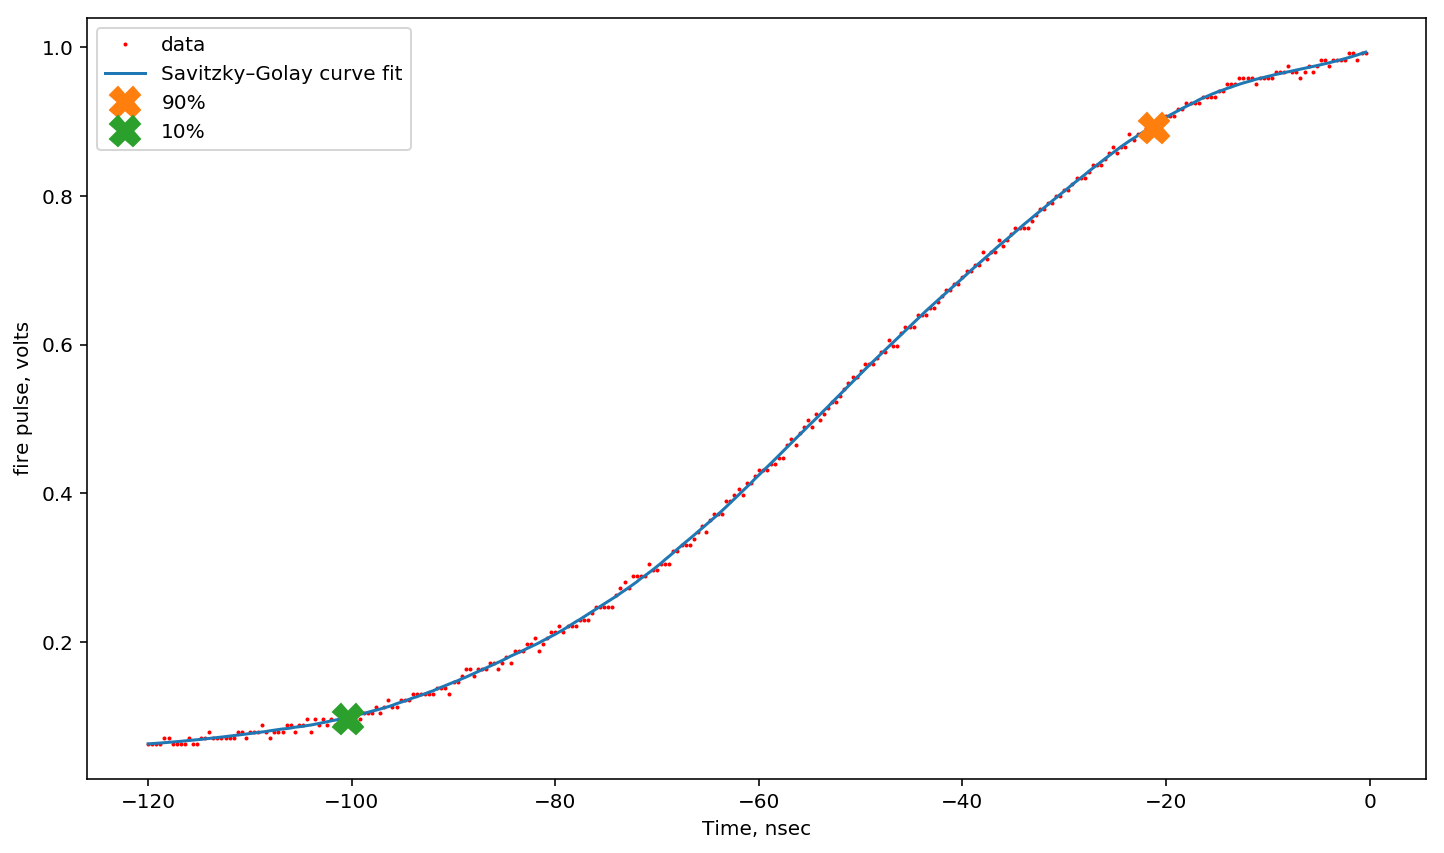

In [11]:
plt.plot(x2_rise,y2_rise,'ro', markersize=1)
plt.plot(x2_rise,y2_filtered)
plt.plot(x2_rise[index_90pc],y2_rise[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x2_rise[index_10pc],y2_rise[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

### Rise time for CVR fire pulse
change the name of this data set to CVR fire pulse

In [12]:
# consider only the rising edge
x3_rise = x3[y3_peak_index-120:y3_peak_index]
y3_rise = y3[y3_peak_index-120:y3_peak_index]

y3_filtered = savgol_filter(y3_rise, 51, 3)  # filter the data

index_90pc = (np.abs(y3_filtered-y3_filtered.max()*0.9)).argmin()
index_10pc = (np.abs(y3_filtered-y3_filtered.max()*0.1)).argmin()
rise_time = x3_rise[index_90pc]-x3_rise[index_10pc]

print('peak voltage value: {:.3f} volts'.format(y2_filtered.max()))
print('90% voltage value: {:.3f} volts at {:.0f} ns'.format(y3_filtered[index_90pc], x3_rise[index_90pc]))
print('10% voltage value: {:.3f} volts at {:.0f} ns'.format(y3_filtered[index_10pc], x3_rise[index_10pc]))
print('rise time: {:.0f} ns'.format(rise_time))

peak voltage value: 0.993 volts
90% voltage value: 0.864 volts at -24 ns
10% voltage value: 0.097 volts at -83 ns
rise time: 59 ns


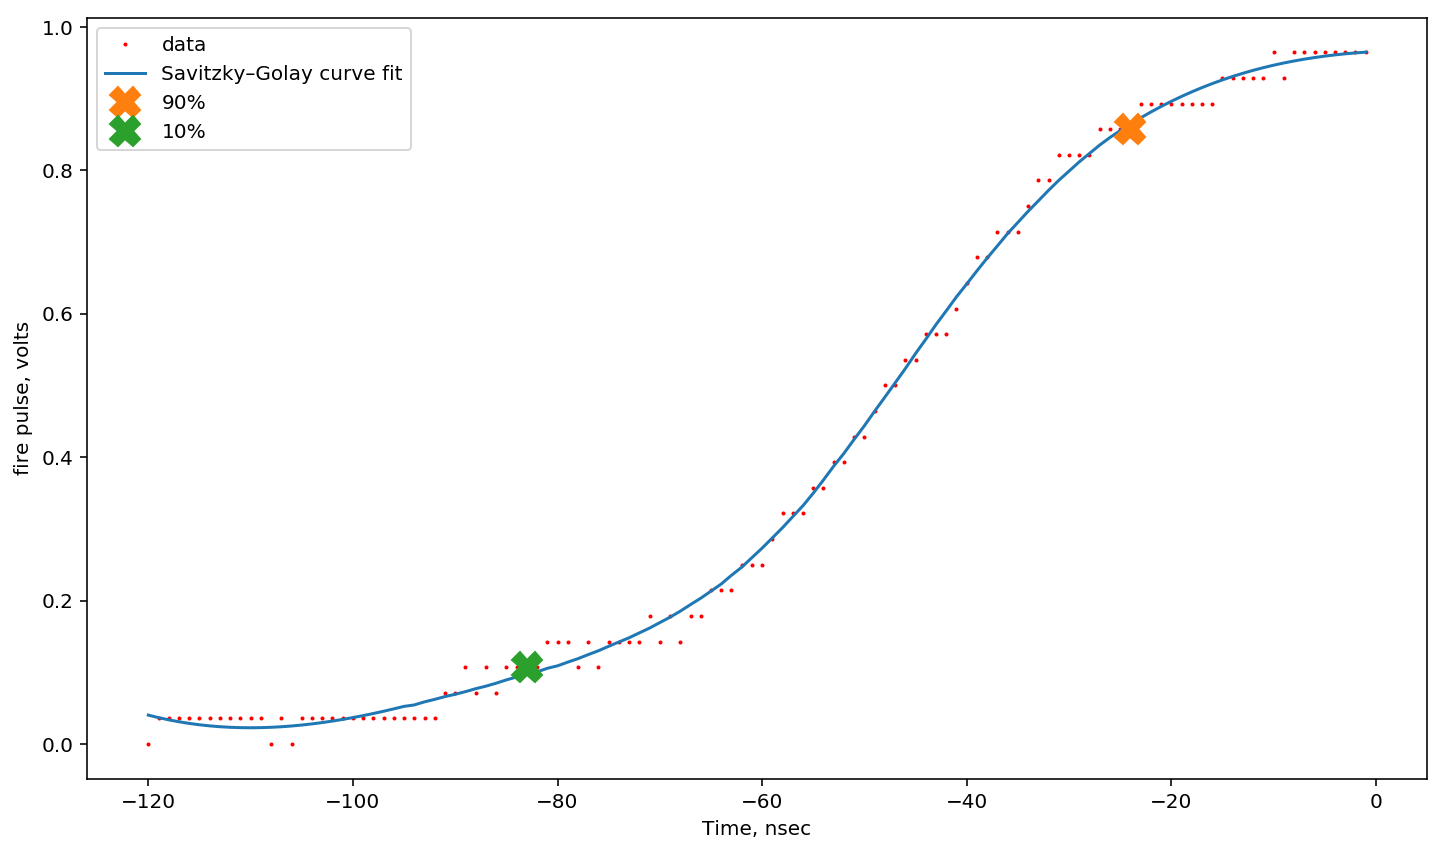

In [13]:
plt.plot(x3_rise,y3_rise,'ro', markersize=1)
plt.plot(x3_rise,y3_filtered)
plt.plot(x3_rise[index_90pc],y3_rise[index_90pc],'X',markersize=15)  # 90% point
plt.plot(x3_rise[index_10pc],y3_rise[index_10pc],'X',markersize=15)  # 10% point
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['data', 'Savitzky–Golay curve fit','90%','10%'], loc='best')
plt.show()

The 90% and 10% X's don't seem to be exactly on the curve.  Need to investigate.

### Comparison of the fire pulse's leading edges
Using RMSE to compare the fire pulses.  The RMSE is the square root of the average of squared errors. The following code blocks use the FIRE 800V fire pulse as the reference data set and compares a curve fit of the FIRE 800V pulse to the FIRE 720V and CVR fire pulses.  Need to calculate a polynomial for the reference pulse so that the RMSE can be run on data sets with the same length.

#### Polynomial fit to the FIRE 800V rising edge data

In [14]:
z = np.polyfit(x1_rise, y1_rise, 5)
fx = np.poly1d(z) # convert it to a function
print(fx)

           5             4            3             2
1.923e-10 x + 4.588e-08 x + 2.07e-06 x - 0.0001198 x + 0.003231 x + 0.9864


A 5th order fits nice over the interval.

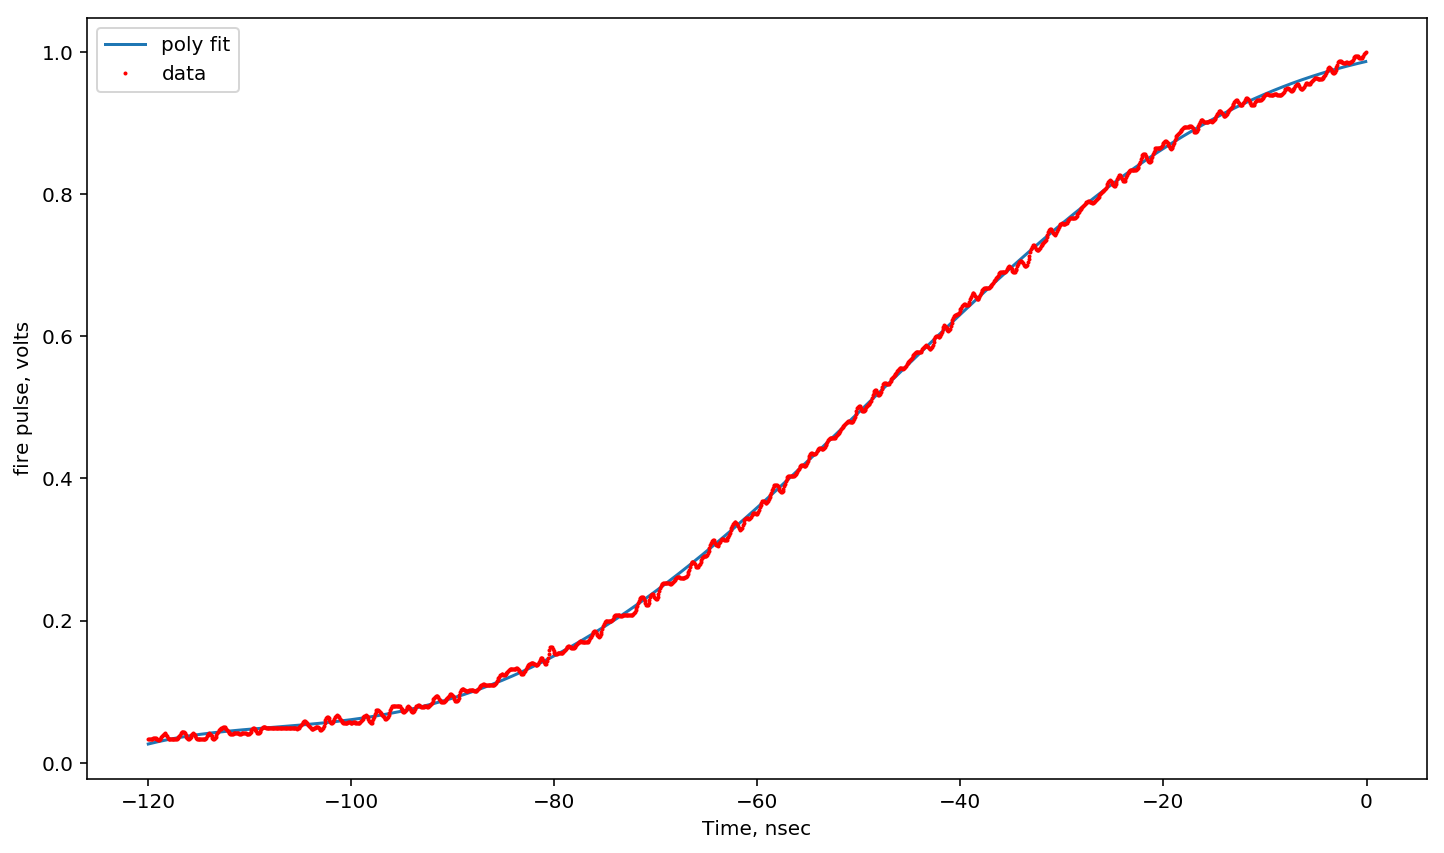

In [15]:
#plot the polynomial and the data
xp = np.linspace(x1_rise[0], x1_rise[-1], 500)
plt.plot(xp, fx(xp), '-')
plt.plot(x1_rise,y1_rise,'ro', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('fire pulse, volts')
plt.legend(['poly fit', 'data'], loc='best')
plt.show()

examine the residuals

In [93]:
#Residuals
xp = np.linspace(x1_rise[0], x1_rise[-1], len(y1_rise))
y1_residuals = fx(xp) - y1_rise

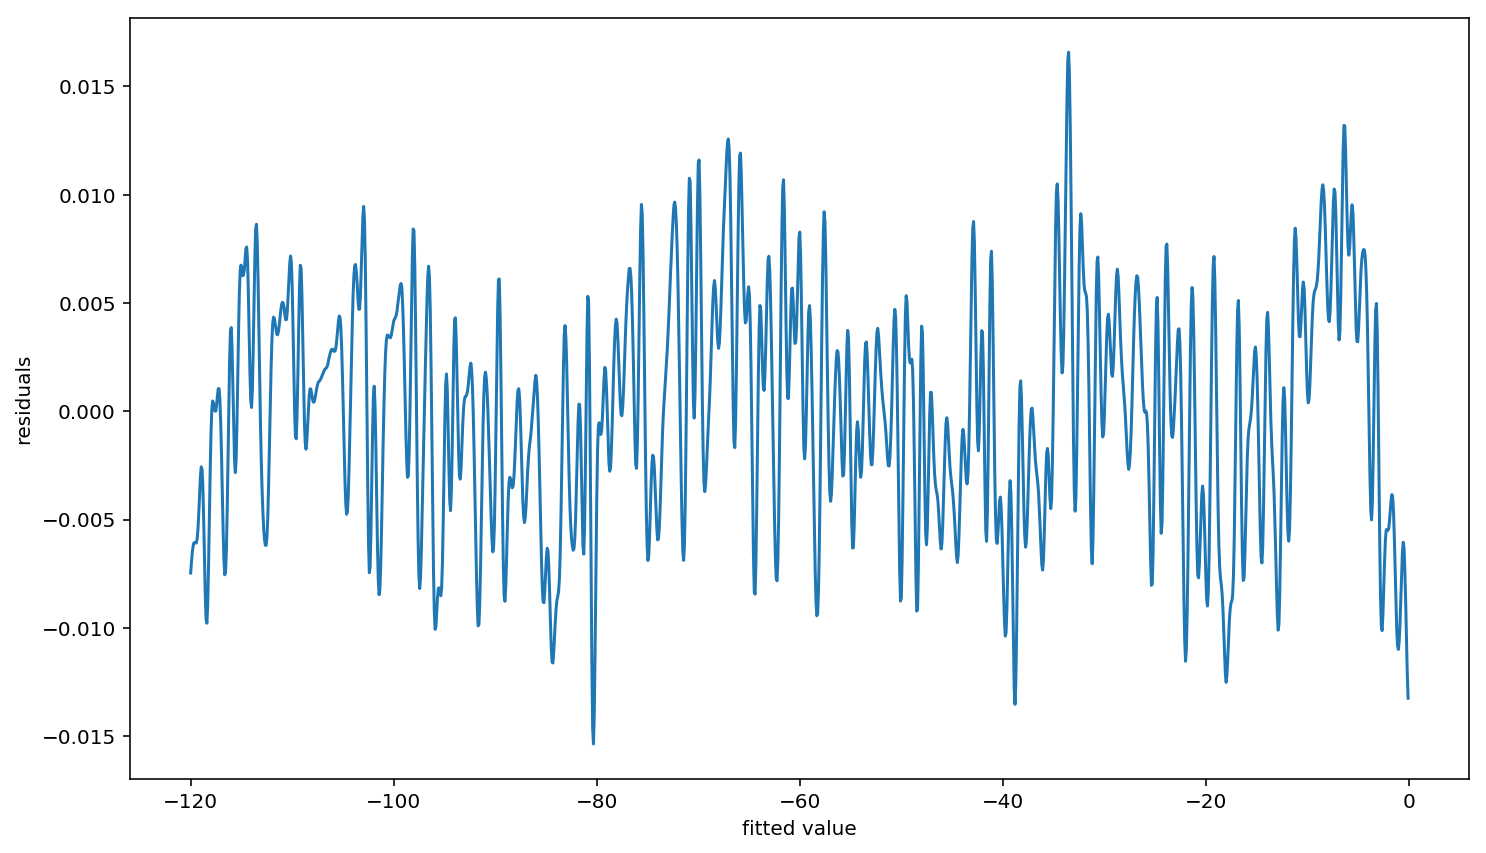

In [94]:
#plot the residuals
plt.plot(xp, y1_residuals, '-')
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

statistics of residuals

In [95]:
y1_residuals.sort()
fit_y1 = stats.norm.pdf(y1_residuals, np.mean(y1_residuals), np.std(y1_residuals))

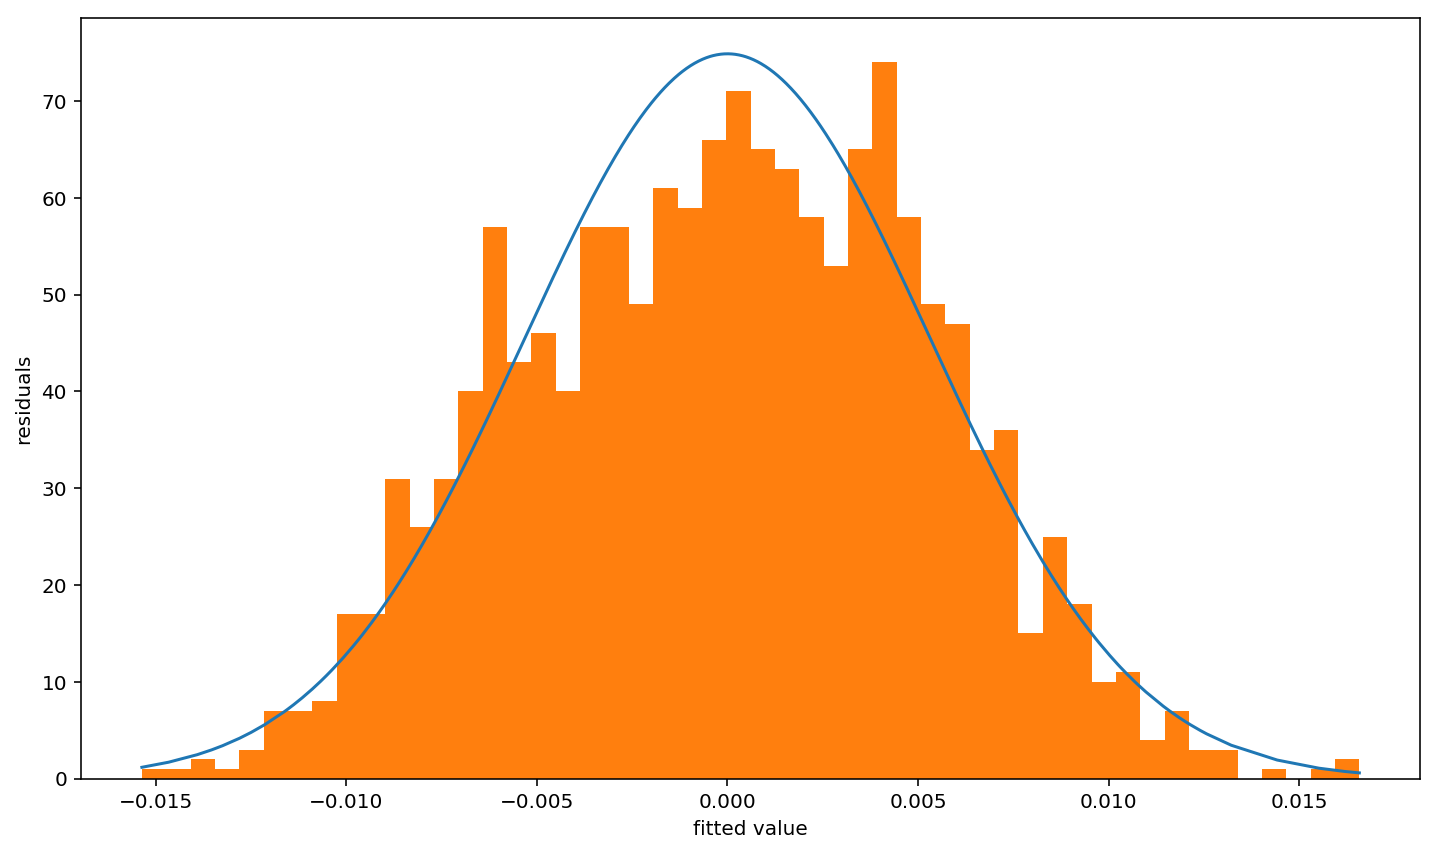

In [103]:
#plot the residuals
plt.plot(y1_residuals, fit_y1)
plt.hist(y1_residuals,bins=50)
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

add some comments,  bell curve, normal distribution

Examine the residuals for FIRE_720V

In [104]:
#Residuals
xp = np.linspace(x2_rise[0], x2_rise[-1], len(y2_rise))
y2_residuals = fx(xp) - y2_rise

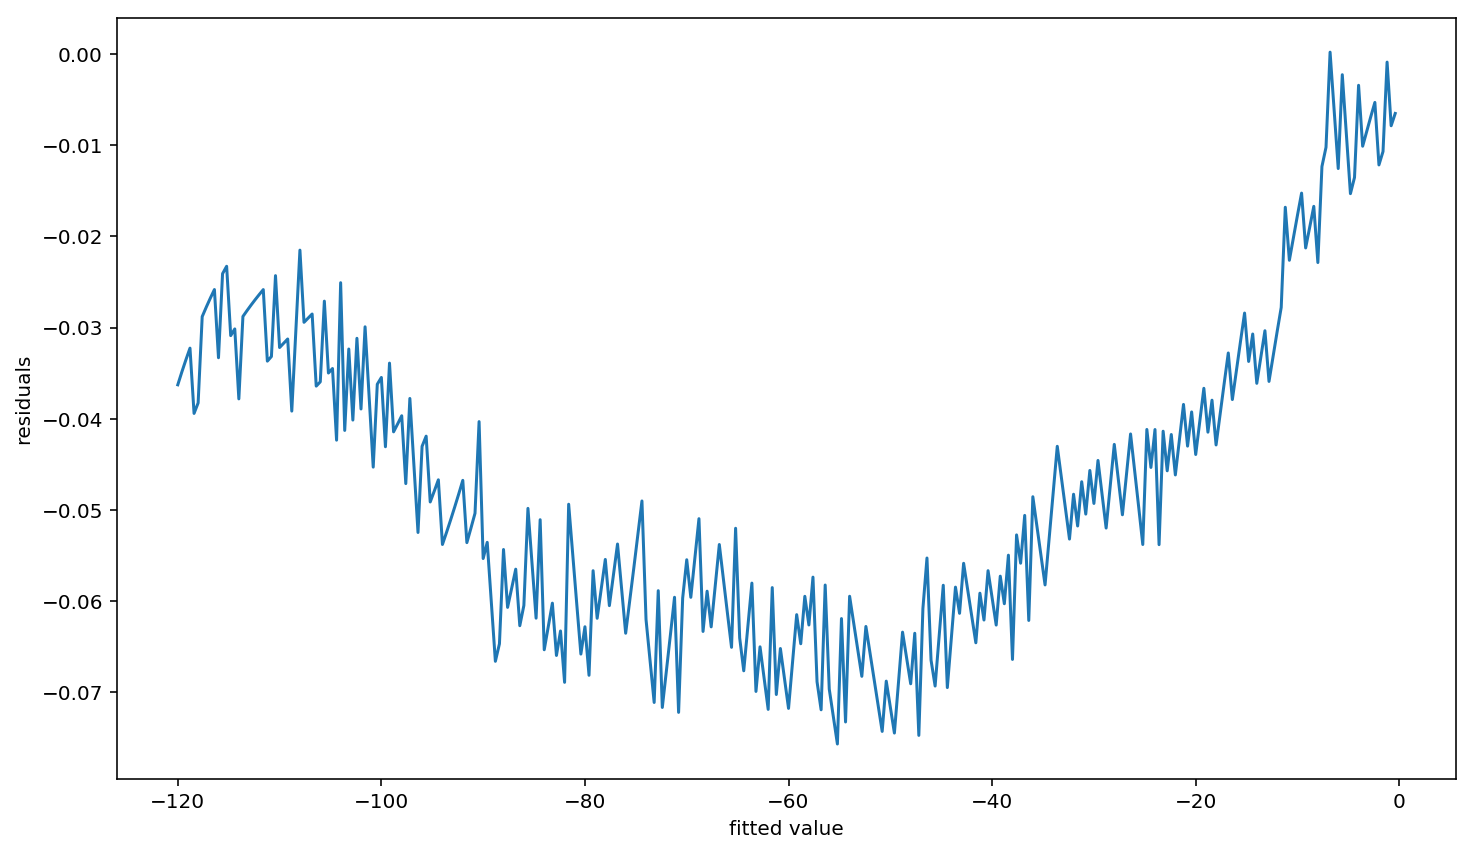

In [105]:
#plot the residuals
plt.plot(xp, y2_residuals, '-')
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [108]:
y2_residuals.sort()
fit_y2 = stats.norm.pdf(y2_residuals, np.mean(y2_residuals), np.std(y2_residuals))

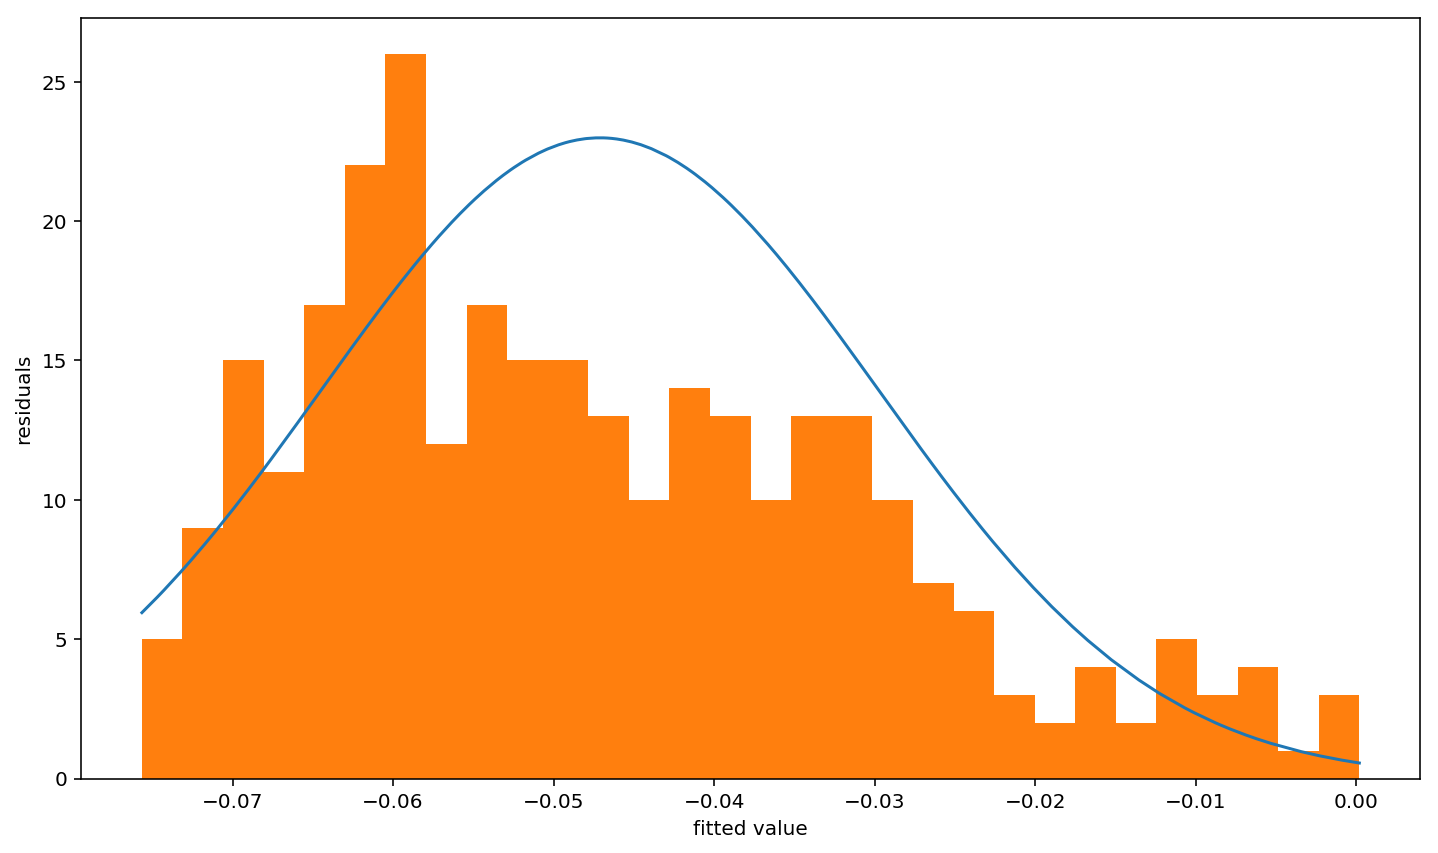

In [112]:
#plot the residuals
plt.plot(y2_residuals, fit_y2)
plt.hist(y2_residuals,bins=30)
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [113]:
np.mean(y2_residuals)

-0.04711829549005149

Examine the residuals for CVR_fire_pulse

In [116]:
#Residuals
xp = np.linspace(x3_rise[0], x3_rise[-1], len(y3_rise))
y3_residuals = fx(xp) - y3_rise

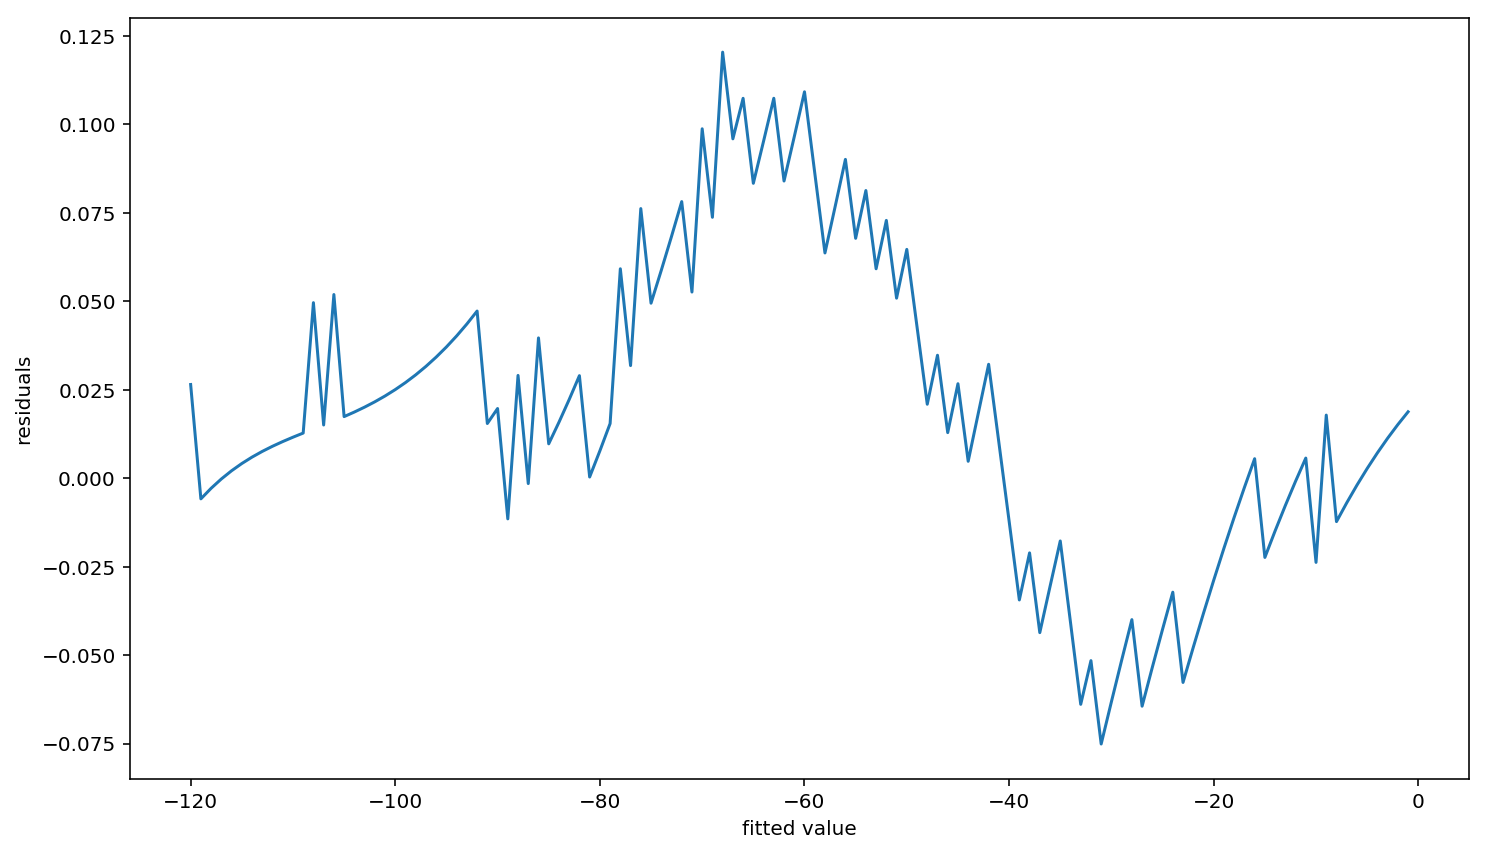

In [117]:
#plot the residuals
plt.plot(xp, y3_residuals, '-')
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [120]:
y3_residuals.sort()
fit_y3 = stats.norm.pdf(y3_residuals, np.mean(y3_residuals), np.std(y3_residuals))

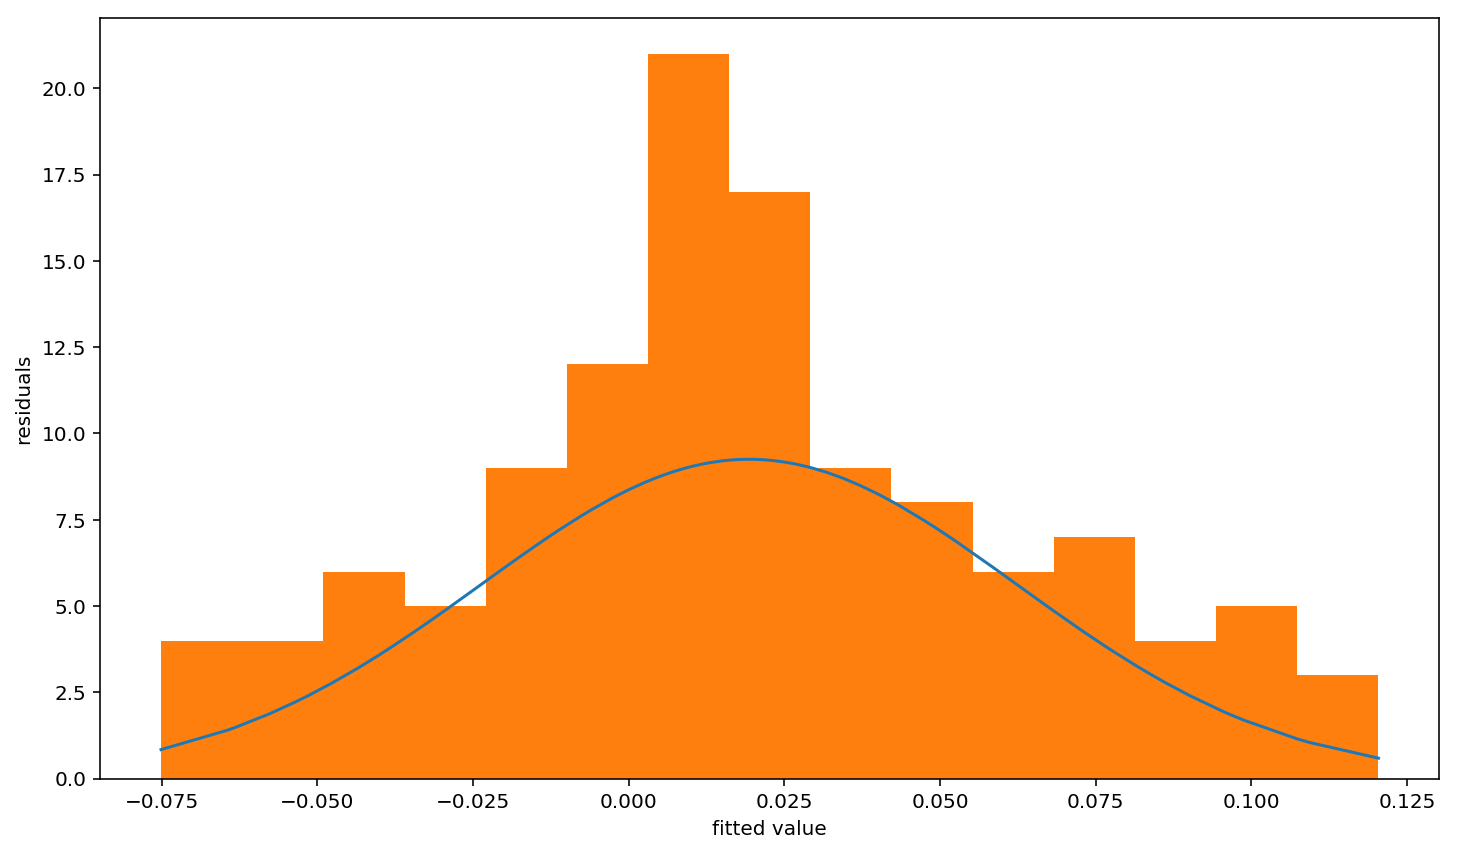

In [123]:
#plot the residuals
plt.plot(y3_residuals, fit_y3)
plt.hist(y3_residuals,bins=15)
plt.xlabel('fitted value')
plt.ylabel('residuals')
plt.show()

In [124]:
np.mean(y3_residuals)

0.019322576686577886

some comments about residuals

#### Calculate the root-mean-square error (RMSE)
The RMSE is the square root of the average of squared errors. The following code blocks use the FIRE 800V fire pulse as the reference fire pulse and compares a curve fit of the FIRE 800V pulse to the FIRE 720V and CVR fire pulses.  

In [16]:
# function to calculate the rmse
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Using FIRE_800V as the reference, calculate the rmse between FIRE_800V and itself, just the rising edge segment of the pulse.

In [17]:
rmse(y1_rise, y1_rise)

0.0

Calculate the rmse between FIRE_800V and the polynominal fit to FIRE_800V

In [18]:
xp = np.linspace(x1_rise[0], x1_rise[-1], len(y1_rise))
rmse(y1_rise, fx(xp))

0.005327652281802567

Calculate the rmse between FIRE_720V and the polynominal fit to FIRE_800V

In [19]:
xp = np.linspace(x2_rise[0], x2_rise[-1], len(y2_rise))
rmse(y2_rise, fx(xp))

0.0502130803382283

Calculate the rmse between CVR_fire_pulse and the polynominal fit to FIRE_800V

In [20]:
xp = np.linspace(x3_rise[0], x3_rise[-1], len(y3_rise))
rmse(y3_rise, fx(xp))

0.047251018193380616

#### Some RMSE tests
I couldn’t find any rules of thumb that say how low the RMSE should be for two data set to be considered a close match.  Here is some test data with known differences and the calculated RMSE.  The test data is based on 1/4 cycle of a sine wave.

Case 1: two sine waves, 180 degress out of phase plus an increasing offset

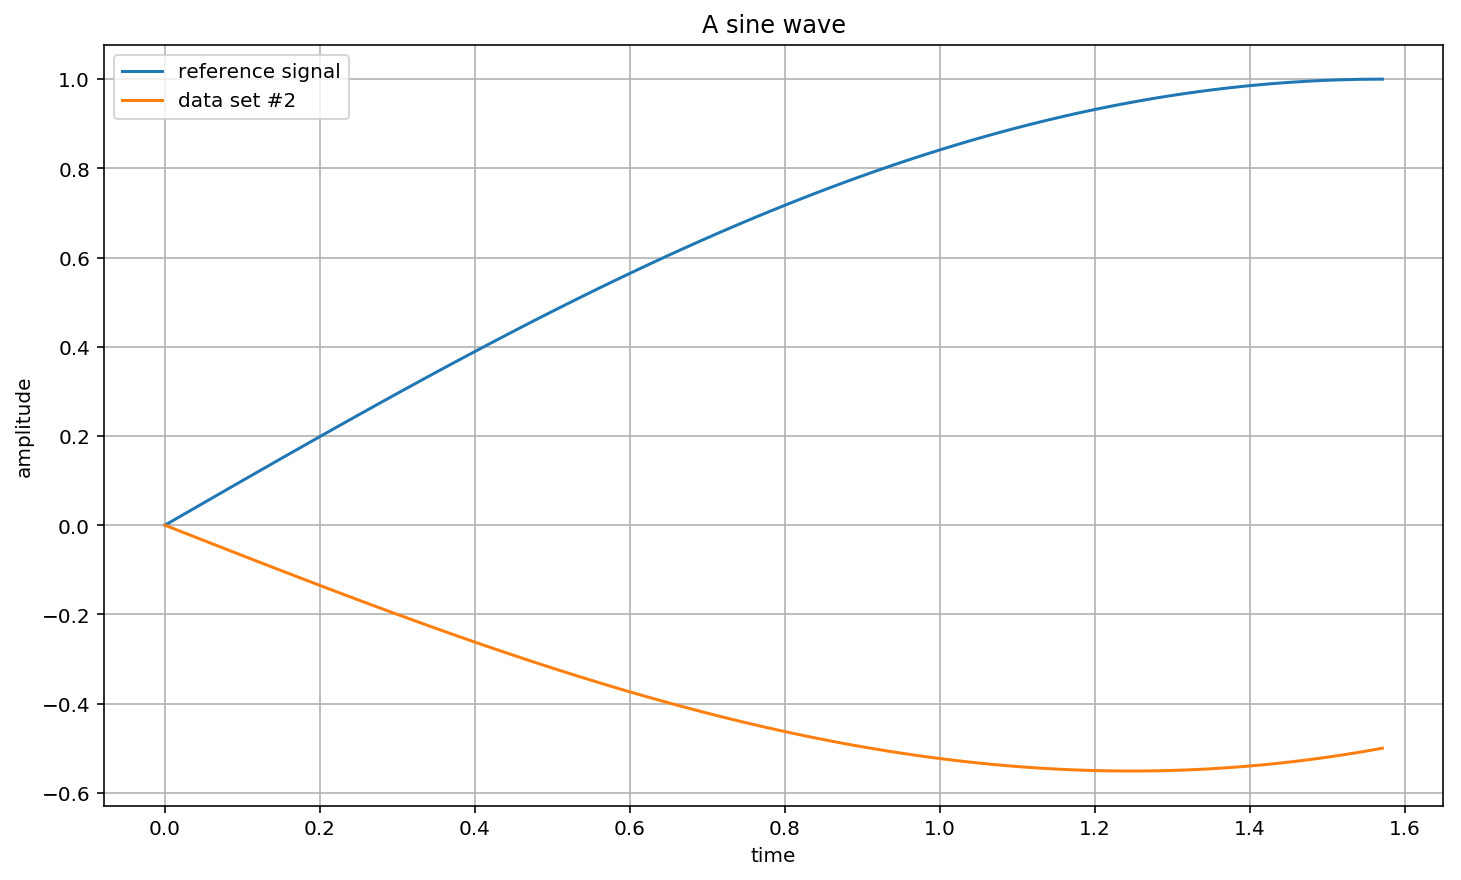

In [21]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = np.linspace(0.0, 0.5, 100)
phase = 180*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t+phase) + offset
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [22]:
rmse(ref_signal, ds2)

1.1275076935782502

Case 2: two sine waves, in phase plus an increasing offset

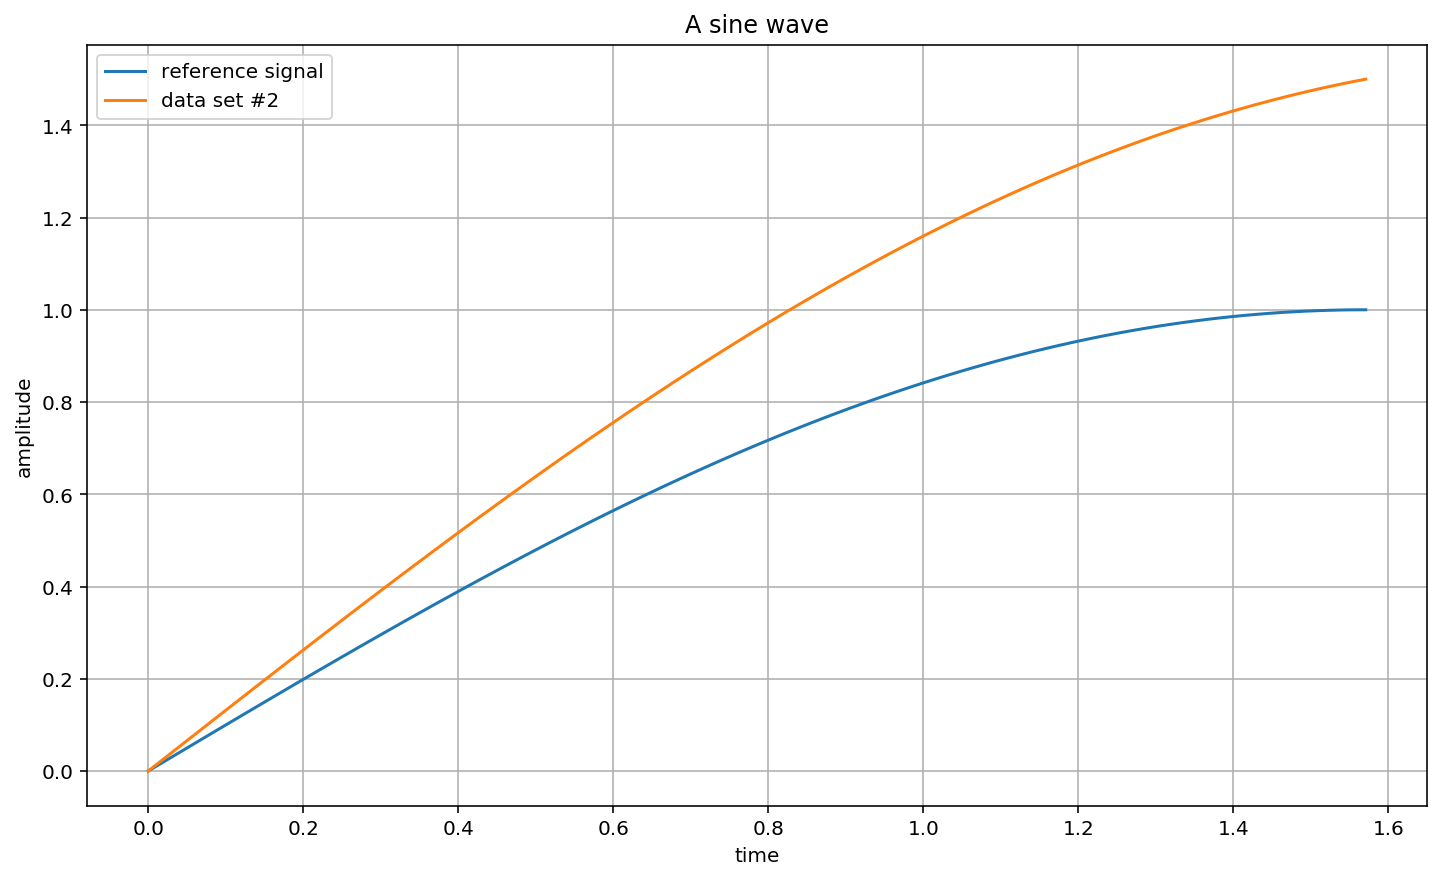

In [23]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = np.linspace(0.0, 0.5, 100)
phase = 0*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t+phase) + offset
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [24]:
rmse(ref_signal, ds2)

0.2894031940981453

Case 3: two sine waves, 10 degree phase error, no offset, with some noise

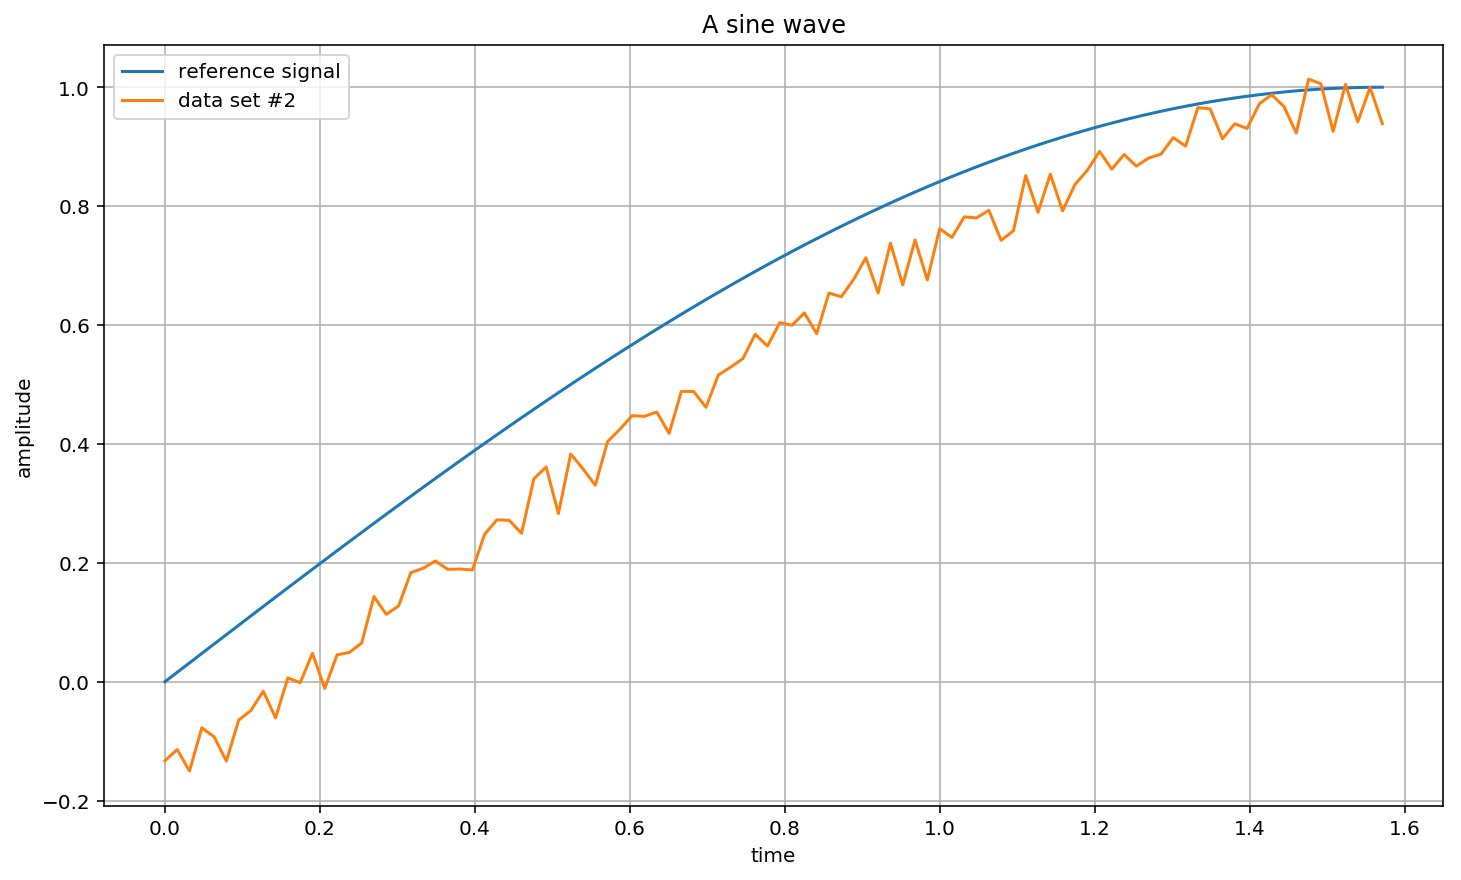

In [25]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = 0 #np.linspace(0.0, 0.5, 100)
noise = np.random.random_sample((100,)) - 0.5
phase = 10*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t-phase) + offset + noise*0.1
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [26]:
rmse(ref_signal, ds2)

0.12675238962744156

Case 4: two sine waves, 3 degrees of phase error, 0.1 offset, with some noise

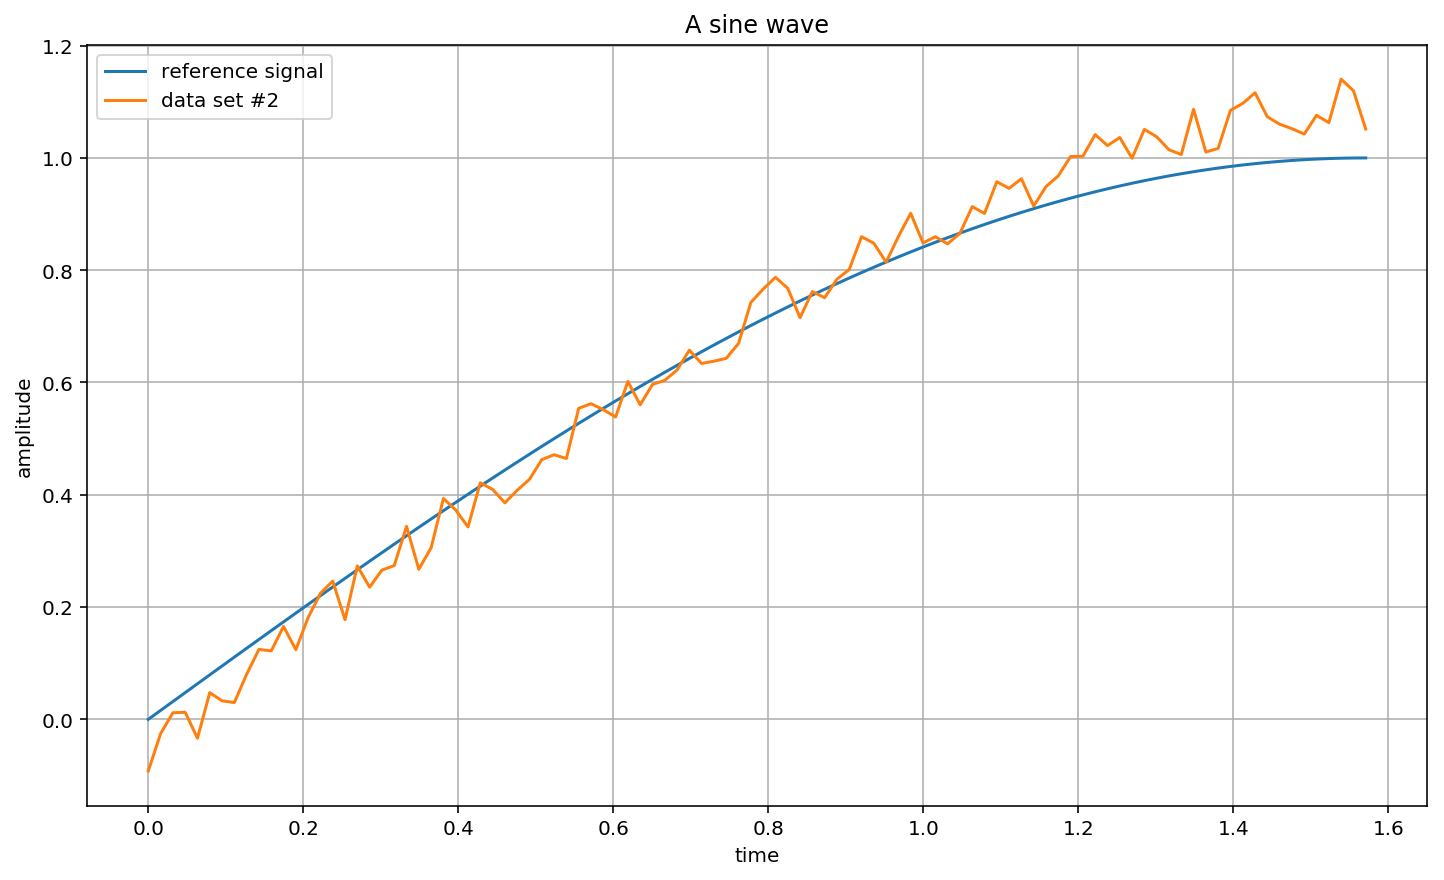

In [27]:
end = 0.5*np.pi
t = np.linspace(0.0, end, 100)
offset = np.linspace(0.0, 0.1, 100)
noise = np.random.random_sample((100,)) - 0.5
phase = 3.0*np.pi/180
ref_signal = np.sin(t)
ds2 = np.sin(t-phase) + offset + noise*0.1
plt.plot(t, ref_signal)
plt.plot(t, ds2)
plt.grid(True)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('A sine wave')
plt.legend(['reference signal', 'data set #2'], loc='best')
plt.show()

In [28]:
rmse(ref_signal, ds2)

0.053976604790993622

#### RMSE Conclusions
Test case 4 had only slight differences between the reference waveform and the test data set.  The RMSE was calculated to be 0.05.  I think we can conclude that if the RMSE is less than 0.05, the correlation between the data sets is good.  Visual inspection of the plotted data confirms this.  For fire pulse type signals, a RMSE greater than 0.1 probably means that the two data sets are only somewhat simular.

### Calculate the current and voltage
Using the values of the resistors in the current viewing resistors, calculate the voltage and current.

The FIRE_800V fire pulse is measured by a current viewing resistor with R1 = 5.462, R2 = 0.005065.

In [29]:
R1 = 5.462
R2 = 0.005065
current = df1['Voltage'].values.max()*R1/R2
print('UCHFS1000 peak current = {:.1f} amps, voltage = {:.1f} volts'.format(current, 800))

UCHFS1000 peak current = 1143.1 amps, voltage = 800.0 volts


#### FIRE 720V Fire pulse

In [30]:
R1 = 5.462
R2 = 0.005065
current = df2['Voltage'].values.max()*R1/R2
print('UCHFS1000 peak current = {:.1f} amps, voltage = {:.1f} volts'.format(current, 720))

UCHFS1000 peak current = 1030.9 amps, voltage = 720.0 volts


#### CVR Fire pulse
R1 = 0.5143 and R2 = 0.004907

In [31]:
R1 = 0.5143
R2 = 0.004907
current = df3['Voltage'].values.max()/R2
voltage = df3['Voltage'].values.max()*(R1+R2)/R2
print('FTSA peak current = {:.1f} amps, voltage = {:.1f} volts'.format(current, voltage))

FTSA peak current = 2282.5 amps, voltage = 1185.1 volts


### FFT
I thought it might be interesting to see what the frequency content of a fire pulse is, so what follows is an FFT analysis of the FIRE_800V waveform.  rfft is the scipy discrete fourier transform of a real sequence.

In [32]:
# FIRE 800V, reload the data
df1 = pd.read_pickle('FIRE_800V.pkl')
x1 = df1['Time'].values
y1 = df1['Voltage'].values
#y1 = y1/y1.max()  # normalize the amplitude
x1 -= x1[0]  # set time start to 0
# trim the data set so the peak is in the center
y1_peak_index = y1.argmax()
x1 = x1[0:y1_peak_index*2]
y1 = y1[0:y1_peak_index*2]

In [33]:
n = len(x1)
print('length of data set: {:d} samples'.format(n))
dt = x1[1]-x1[0]
print('time step: {:.3e} sec'.format(dt))

print('data capture interval: {:.1f} ns'.format(1e9*n*dt))
print('sample frequency: {:,.3f} GHz'.format(1e-9/dt))
print('Nyquist frequency: {:,.1f} GHz'.format(1e-9/dt/2))
print('peak value: {:.3f} volts'.format(y1.max()))

length of data set: 5000 samples
time step: 8.000e-11 sec
data capture interval: 400.0 ns
sample frequency: 12.500 GHz
Nyquist frequency: 6.3 GHz
peak value: 1.060 volts


Plot the data, the data windowed and the window.  The tukey window is also known as a tapered cosine window.  Here we just want to eliminate the discontinuities at the ends of the data set.

In [34]:
w = tukey(n)
y1w = y1*w

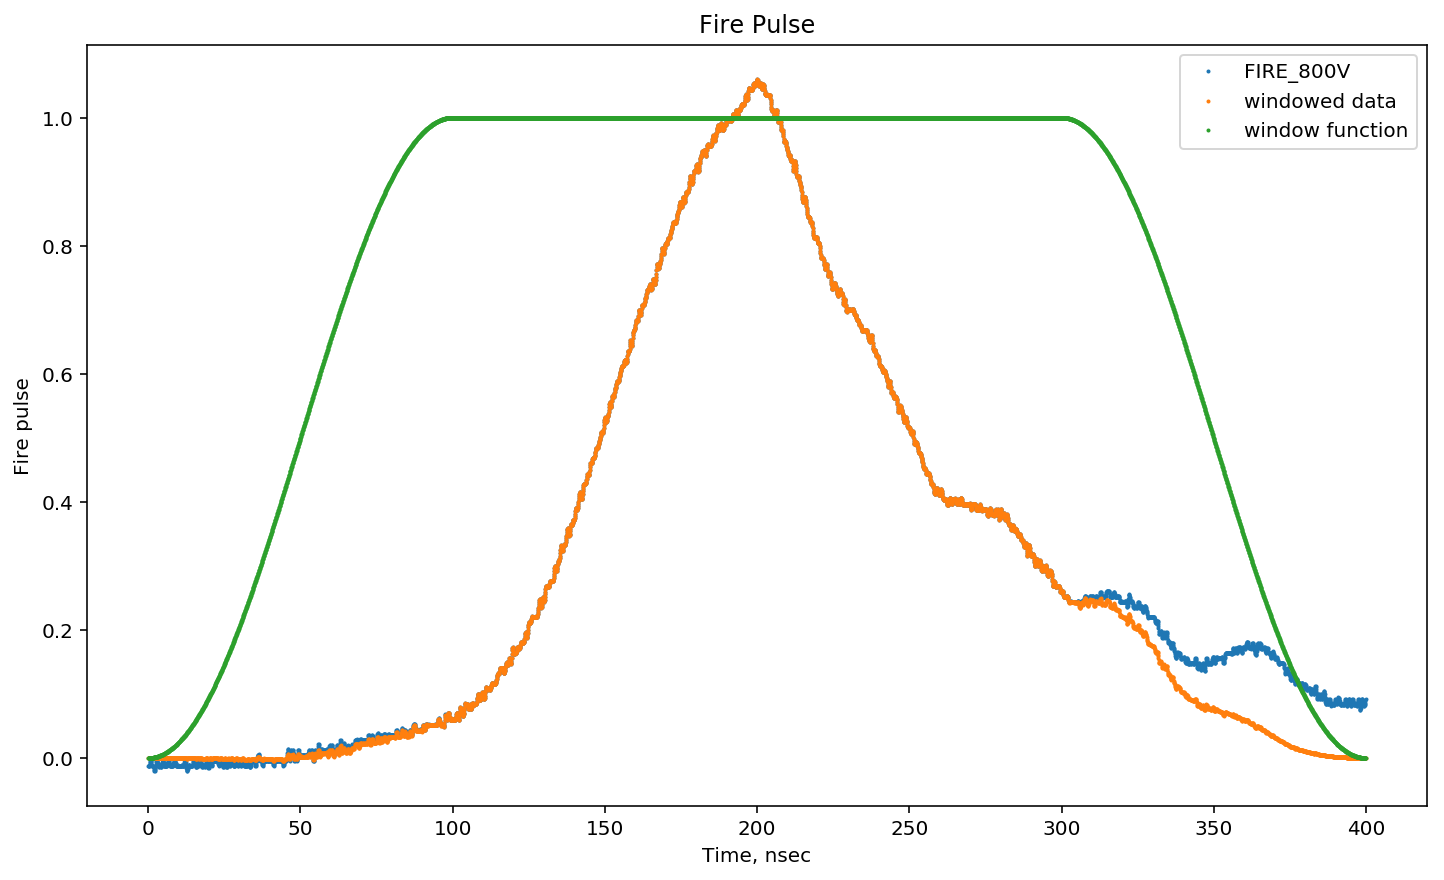

In [35]:
# plot the fire pulse
plt.plot(x1*1e9,y1,'o', markersize=1)
plt.plot(x1*1e9,y1w,'o', markersize=1)
plt.plot(x1*1e9,w,'o', markersize=1)
plt.xlabel('Time, nsec')
plt.ylabel('Fire pulse')
plt.legend(['FIRE_800V', 'windowed data', 'window function'], loc='best')
plt.title('Fire Pulse')
plt.show()

The fftfreq() function returns a float array containing the frequency bin centers in cycles per unit of the sample spacing (with zero at the start). Since the sample spacing is in seconds, the frequency unit is cycles/second.

Thefft() function computes the one-dimensional n-point discrete Fourier Transform (DFT) of a real-valued array by means of an efficient algorithm called the Fast Fourier Transform (FFT).

In [36]:
sample_freq = scipy.fftpack.fftfreq(n, d=dt)
fft_y1 = scipy.fftpack.fft(y1w)

Plot the full data set on a semilog scale with the amplitudes normalized.

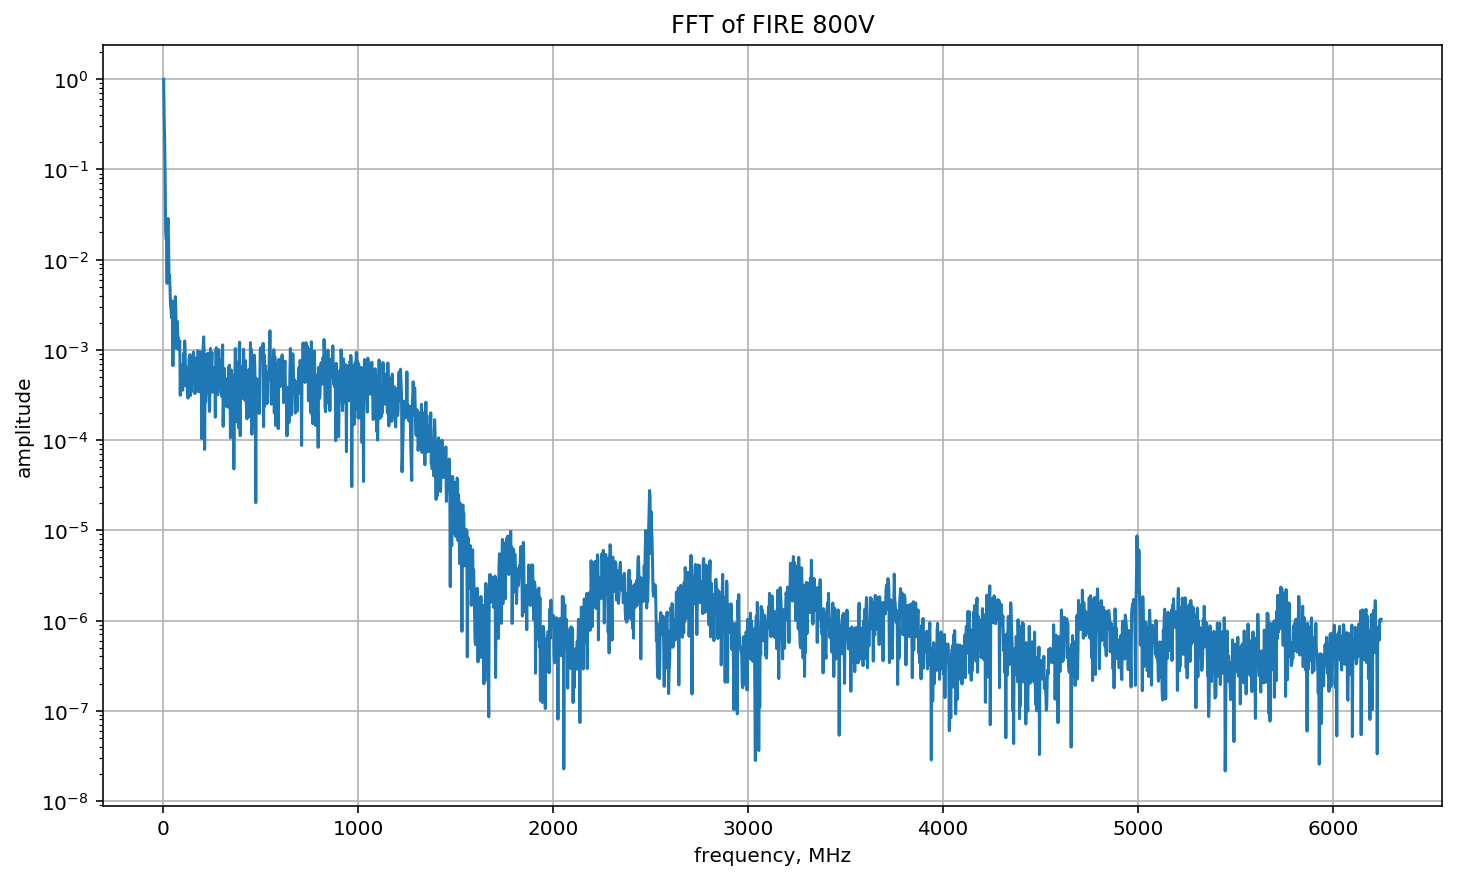

In [37]:
pidxs = np.where(sample_freq > 0)
freqs, amplitude = sample_freq[pidxs], np.abs(fft_y1[pidxs])
amplitude /= amplitude.max()
plt.semilogy(freqs/1e6,amplitude)
plt.ylabel('amplitude')
plt.xlabel('frequency, MHz')
plt.title('FFT of FIRE 800V')
plt.grid()
plt.show()

Plotting the data out to about 2GHz.

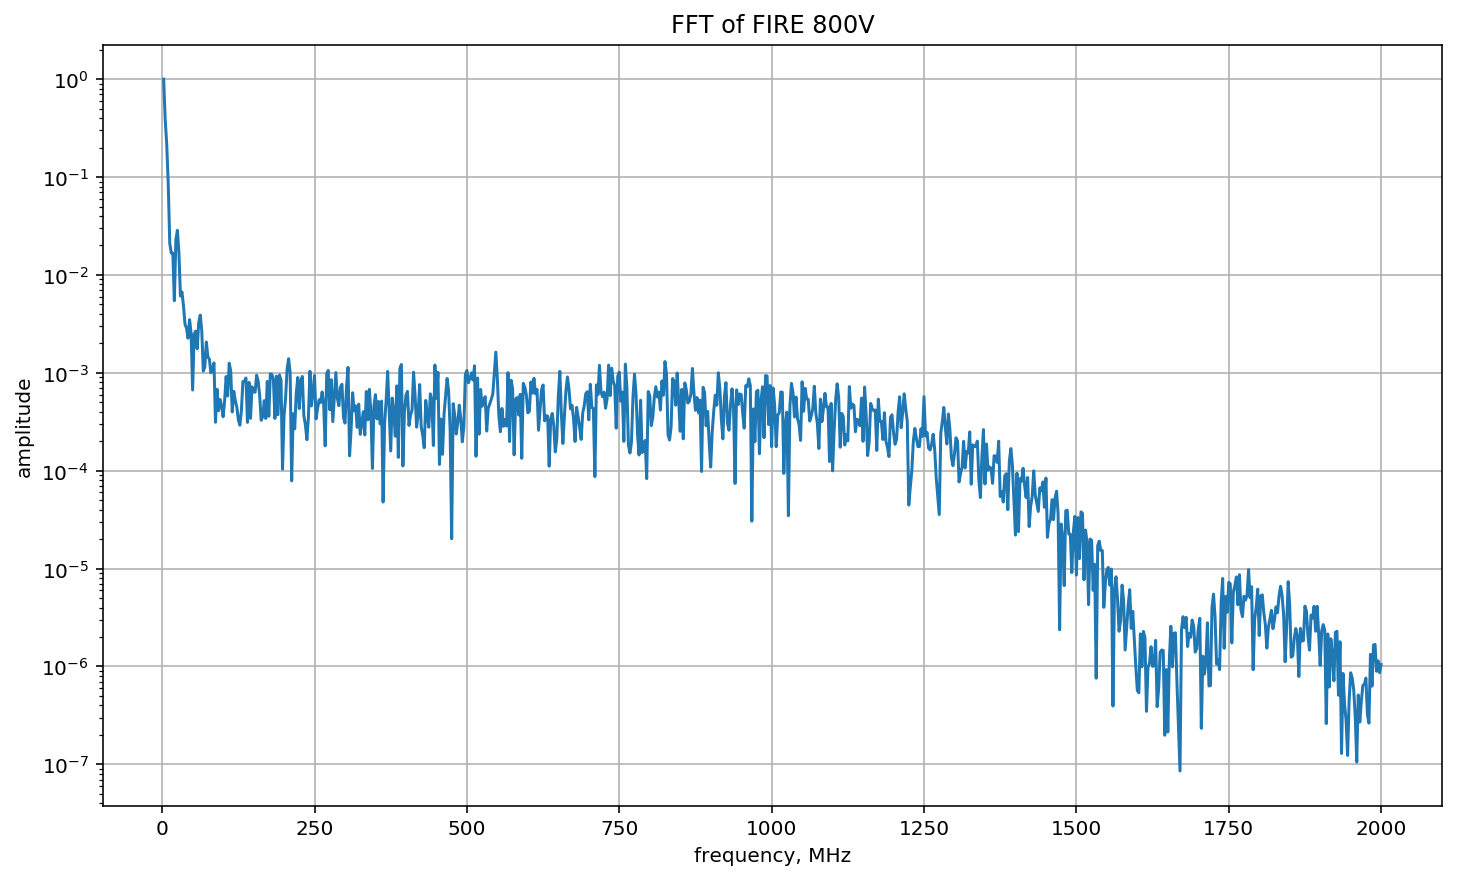

In [38]:
start = 0  #start and ending index, not frequency
end = 800
plt.semilogy(freqs[start:end]/1e6,amplitude[start:end])
plt.ylabel('amplitude')
plt.xlabel('frequency, MHz')
plt.title('FFT of FIRE 800V')
plt.grid()
plt.show()

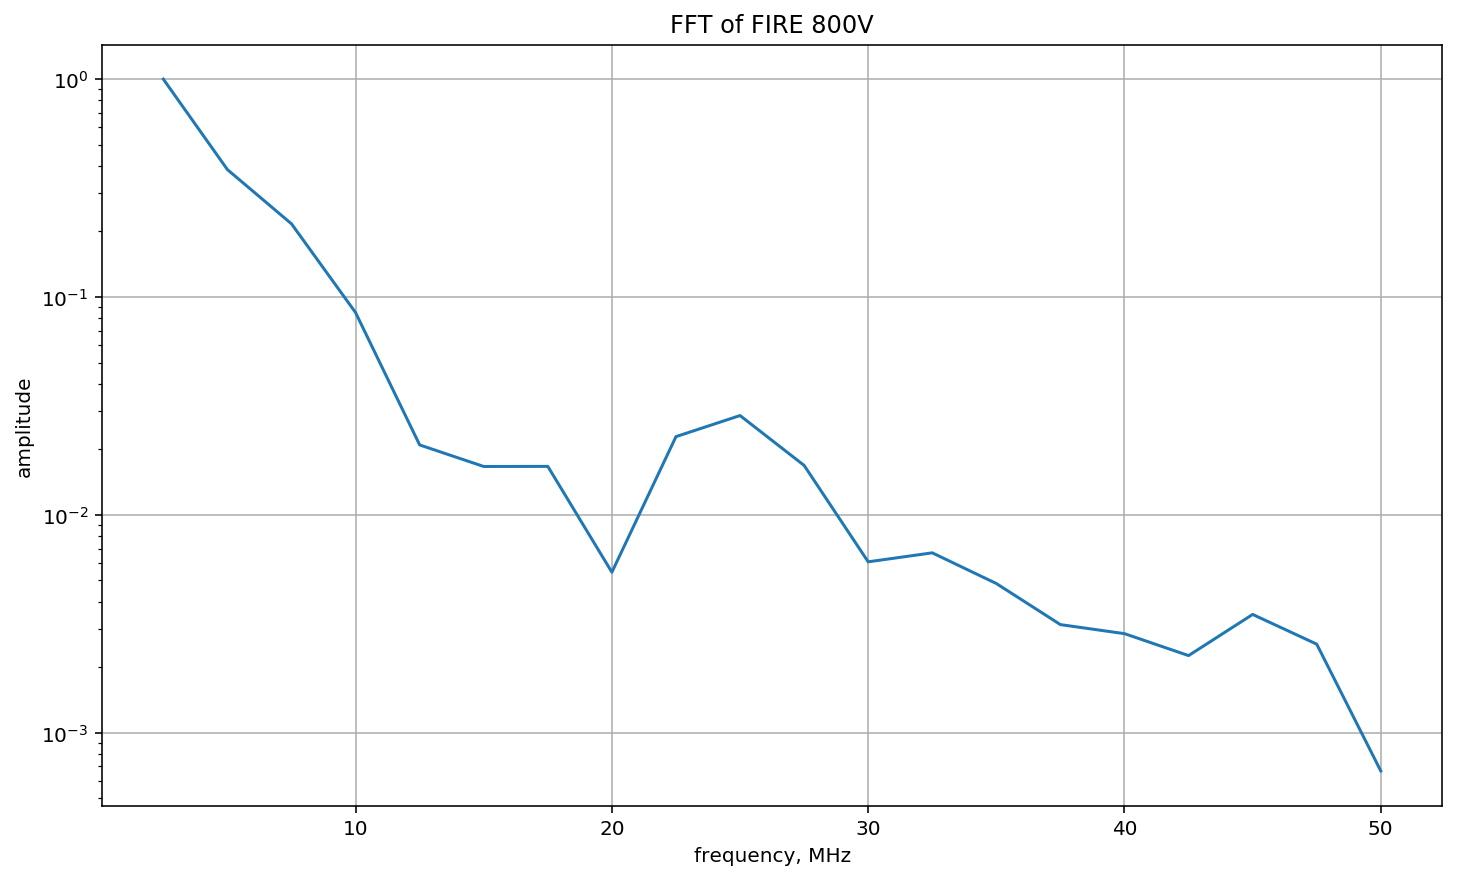

In [39]:
start = 0  #start and ending index, not frequency
end = 20
plt.semilogy(freqs[start:end]/1e6,amplitude[start:end])
plt.ylabel('amplitude')
plt.xlabel('frequency, MHz')
plt.title('FFT of FIRE 800V')
plt.grid()
plt.show()

From the plots above we can see that most of the fire pulse energy is below 10 MHz.  The frequency bins are 2.5MHz wide and beyond the 5th fourier coefficient (12.5 MHz) the amplitude is less than 2% of the peak. This suggests that most of the pulse energy is below 12.5 MHz.  We can integrate the area under the fourier curve across various frequency bands.

The first 5 Fourier coefficients are:

In [312]:
amplitude[0:5]

array([ 1.        ,  0.38443996,  0.21671916,  0.08481506,  0.02094109])

Using numpy's trapezoidal integration function we can compute the area under the power spectrum.

In [325]:
end = 3
print('power below {:.1f}MHz is: {:.1f}%'.format(freqs[end]/1e6,100*np.trapz(amplitude[0:end]**2)/np.trapz(amplitude**2)))

power below 10.0MHz is: 95.2%


In [316]:
total_area = np.trapz(amplitude)
print('area below 12.5MHz: {:.1f}%'.format(100*np.trapz(amplitude[0:4])/total_area))

area below 12.5MHz: 70.6%


In [317]:
freqs[4]/1e6

12.500000000000302

In [326]:
print('power above {:.1f}MHz is: {:.1f}%'.format(freqs[end]/1e6,100*np.trapz(amplitude[end-1:-1]**2)/np.trapz(amplitude**2)))

power above 10.0MHz is: 4.8%


energy is the area squard. 

PSD is W/Hz

power density is v^2/Hz

Then, starting at the lowest frequency in the range and moving upward, the power distributed in each frequency is summed until this sum is 0.5% of the total power. This gives the lower frequency value. Next, starting at the highest frequency in the range and moving downward, the power distributed in each frequency is summed until 0.5% of the total power is reached. This gives the upper frequency value. The bandwidth between the 0.5% power frequency points is the occupied bandwidth.

the power into a resistor is $\frac{v^2}{R}$.  normalizing R=1, the power is just $v^2$